#### Plot longest sequence of +ve and -ve returns for a given set of symbols and date range 

In [68]:
import yfinance as yf 
import pandas as pd 
from datetime import datetime, timedelta 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
syms = ['AAPL', 'MSFT']
start_date = '2020-01-01'
end_date   = '2021-11-30'

In [29]:
def get_data(sym):
    data_df = yf.download(sym, start_date, end_date)
    data_df['rets'] = data_df['Adj Close']/data_df['Adj Close'].shift(1) - 1
    data_df.dropna(axis=0, how='any', inplace=True)
    df = data_df.reset_index()[['Date', 'rets']].rename(columns={'Date':'dates'})
    
    return df

In [26]:
def get_group_size(df):
    df['sign'] = np.where(df['rets'] < 0, -1, 1)
    df['sign_change'] = np.where(df['sign'] == df['sign'].shift(1), 0, 1)
    df['group'] = df.groupby(df['dates'].dt.month)['sign_change'].cumsum()
    df['group_size'] = df.groupby([df.dates.dt.month, df.group])['group'].transform('count')
    return df.groupby([df.dates.dt.year, df.dates.dt.month, df.sign]).agg(max_goup_size=('group_size', 'max'))

In [58]:
def agg_plot_data(): 
    agg_data = pd.DataFrame()
    for sym in syms:
        df = get_data(sym)
        sym_agg_data = get_group_size(df)
        sym_agg_data = sym_agg_data.add_prefix(sym + '_')
        agg_data = pd.concat([agg_data, sym_agg_data], axis=1)
    agg_data.index.names = ['year', 'month', 'sign']
    agg_data = agg_data.reset_index()
    agg_data['yyyymm'] = agg_data['year'].astype(str) + '-' + agg_data['month'].astype(str)
    agg_data = agg_data.drop(['year', 'month'], axis=1)
    y_columns = [ val for val in agg_data.columns if '_max_goup_size' in val ]
    
    return agg_data, y_columns

In [66]:
def plot_data(agg_data, y_columns):
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    agg_data[agg_data['sign'] == 1].plot(ax=axes[0], x='yyyymm', y=y_columns, kind='line', grid=True, title='+ve returns', rot=30) 
    agg_data[agg_data['sign'] == -1].plot(ax=axes[1], x='yyyymm', y=y_columns, kind='line', grid=True, title='-ve returns', rot=30)
    plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


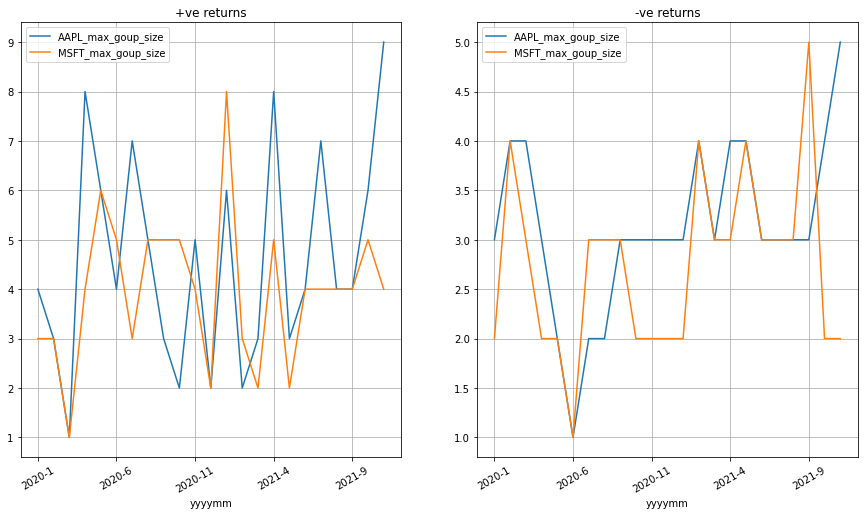

In [67]:
final_df, cols = agg_plot_data()
plot_data(agg_data, cols)